In [1]:
%load_ext autoreload
%autoreload 2

import hydra
import matplotlib.pyplot as plt
import numpy as np
import xarray
plt.style.use("bmh")


In [ ]:
import itertools
import gnss_tid.image
import gnss_tid.synthetic
import gnss_tid.parameter


def run_trial(snr, wl, ps):
    period = wl * 1000 / (60 * ps)
    print(f"{snr = }, {wl = }, {ps = }, {period = }")
    data = gnss_tid.synthetic.constant_model(
        center=xarray.DataArray([0, 0], dims=["ci"]),
        wavelength=wl,
        phase_speed=ps,
        xlim=(-1500, 1500),
        ylim=(-1500, 1500),
        snr=snr,
        hres=20,
    )
    data["image"] = data["image"].rolling(x=3, y=3, center=True, min_periods=1).median()
    params, tau, patches = gnss_tid.parameter.estimate_parameters_block(
        data,
        kaiser_beta=5,
        Nfft=256,
    )

    errors = (
        xarray.Dataset({
            "wl_error": (params.wavelength - wl),
            "ps_error": (params.phase_speed - ps),
        })
        .drop_vars(["kx", "ky", "x", "y"])
        .stack(p=("px", "py"))
        .assign_coords(r=lambda d: np.hypot(d.px, d.py))
        .reset_index("p", drop=True)
        .expand_dims(snr=[snr], wavelength=[wl], phase_speed=[ps])
    )
    return errors


snr_vals = np.arange(9, -16, -1)
wl_vals = [200, 300, 400]
ps_vals = [100, 200, 300]
results = []
for trial in itertools.product(snr_vals, wl_vals, ps_vals):
    r = run_trial(*trial)
    results.append(r)
results = xarray.merge(results)
results = results.squeeze()

snr = np.int64(9), wl = 200, ps = 100, period = 33.333333333333336
snr = np.int64(9), noise_factor = np.float64(0.2508909535828432)
valid patches for wavelength FFT: 223.22314049586777
valid patches for tau FFT: 225.0
valid phase speeds: 225.0
snr = np.int64(9), wl = 200, ps = 200, period = 16.666666666666668
snr = np.int64(9), noise_factor = np.float64(0.2508909535828432)
valid patches for wavelength FFT: 223.25619834710744
valid patches for tau FFT: 225.0
valid phase speeds: 225.0
snr = np.int64(9), wl = 200, ps = 300, period = 11.11111111111111
snr = np.int64(9), noise_factor = np.float64(0.2508909535828432)
valid patches for wavelength FFT: 223.29752066115702
valid patches for tau FFT: 225.0
valid phase speeds: 225.0
snr = np.int64(9), wl = 300, ps = 100, period = 50.0
snr = np.int64(9), noise_factor = np.float64(0.2508909535828432)
valid patches for wavelength FFT: 224.94214876033058
valid patches for tau FFT: 225.0
valid phase speeds: 225.0
snr = np.int64(9), wl = 300, ps = 200, 

In [2]:
results = xarray.open_zarr("results.zarr", chunks="auto")
results = results.assign_coords(r_norm=results.r / results.wavelength)
results

<xarray.Dataset> Size: 101MB
Dimensions:      (snr: 28, wavelength: 7, tau: 5, time: 57, p: 225)
Coordinates:
  * tau          (tau) int64 40B 10 20 30 40 50
  * wavelength   (wavelength) int64 56B 150 200 250 300 350 400 450
  * snr          (snr) int64 224B 12 11 10 9 8 7 6 ... -10 -11 -12 -13 -14 -15
  * p            (p) int64 2kB 0 1 2 3 4 5 6 7 ... 218 219 220 221 222 223 224
  * time         (time) datetime64[ns] 456B 2025-01-01T00:32:00 ... 2025-01-0...
    r            (p) float64 2kB dask.array<chunksize=(225,), meta=np.ndarray>
    r_norm       (p, wavelength) float64 13kB dask.array<chunksize=(225, 7), meta=np.ndarray>
Data variables:
    wl_error     (snr, wavelength, tau, time, p) float32 50MB dask.array<chunksize=(1, 1, 1, 57, 225), meta=np.ndarray>
    ps_error     (snr, wavelength, tau, time, p) float32 50MB dask.array<chunksize=(1, 1, 1, 57, 225), meta=np.ndarray>
    phase_speed  (wavelength, tau) float32 140B dask.array<chunksize=(1, 1), meta=np.ndarray>

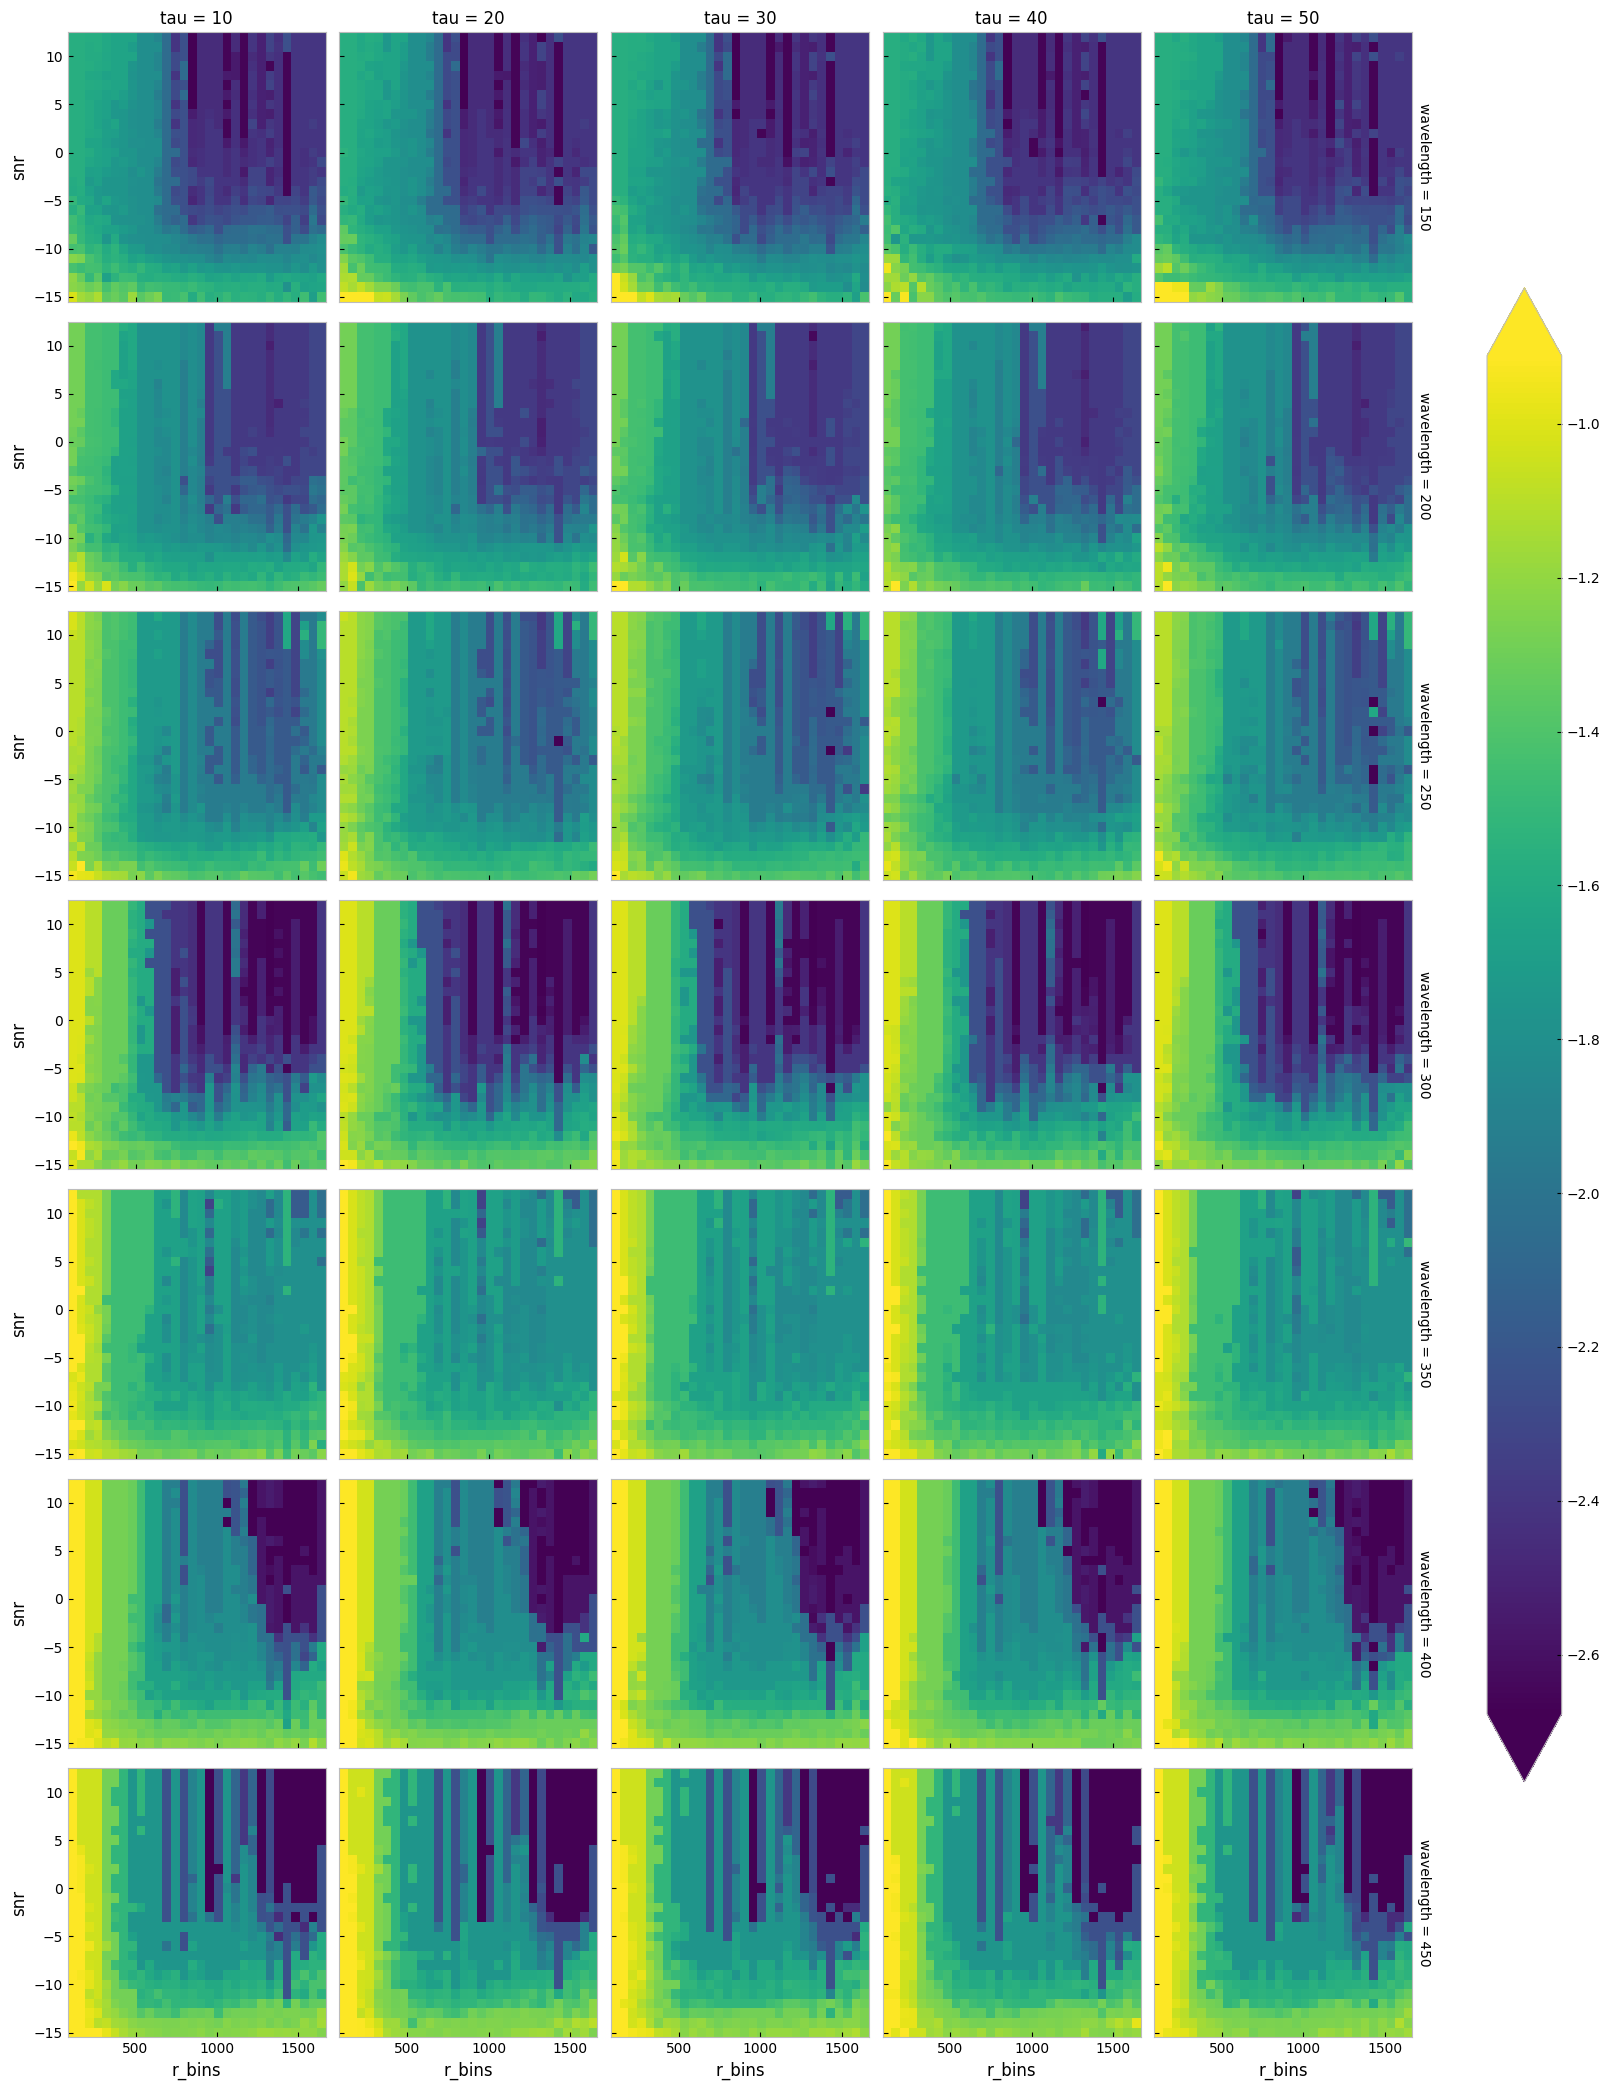

In [9]:
# results.ps_error.median("time").groupby_bins("r_norm", bins=30).median()
# results.ps_error.isel(wavelength=0).median(["time", "phase_speed"]).groupby_bins("r_norm", bins=30).median()
np.log10(abs(results.wl_error / results.wavelength)).median(["time"]).groupby_bins("r", bins=30).median().plot(robust=True, center=False, col="tau", row="wavelength", cbar_kwargs={"fraction": .05})

/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/computat

Text(0.5, 1.0, 'wavelength error')

<Figure size 640x480 with 0 Axes>

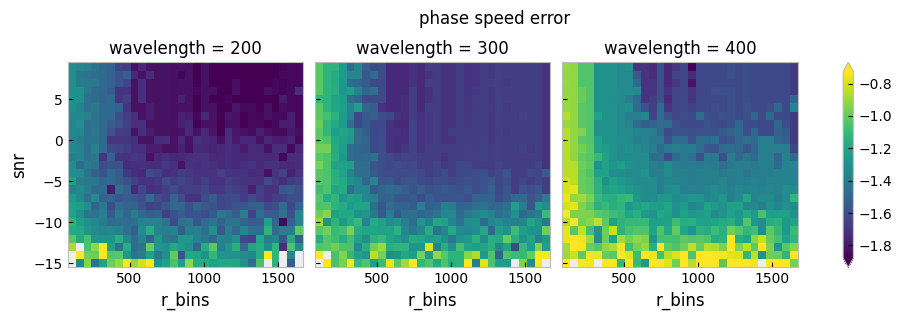

<Figure size 640x480 with 0 Axes>

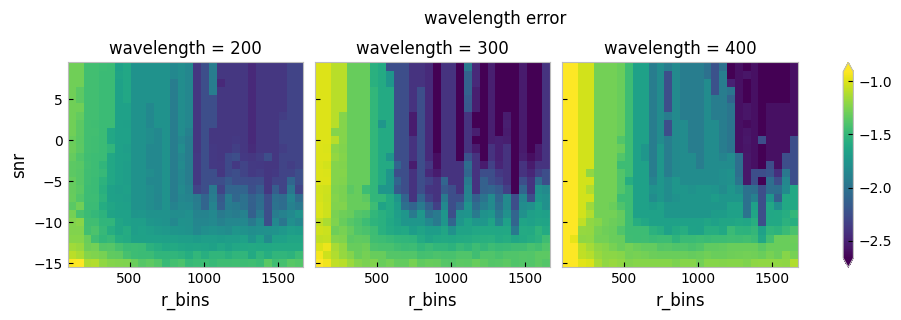

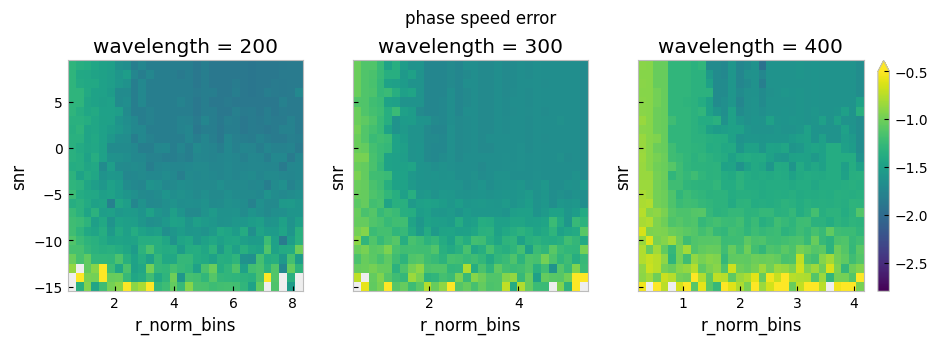

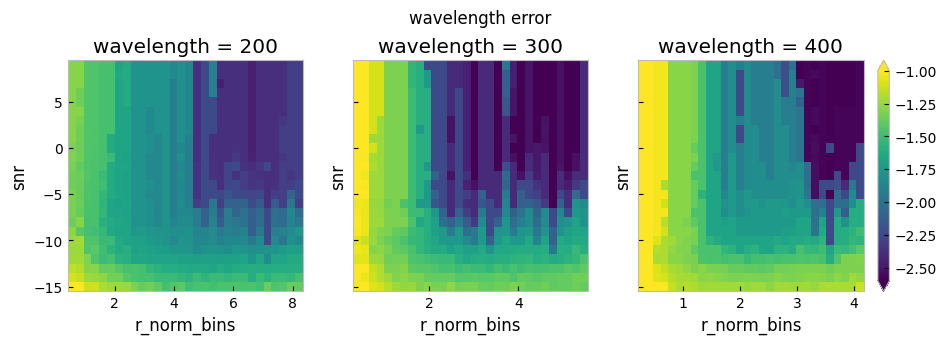

<Figure size 640x480 with 0 Axes>

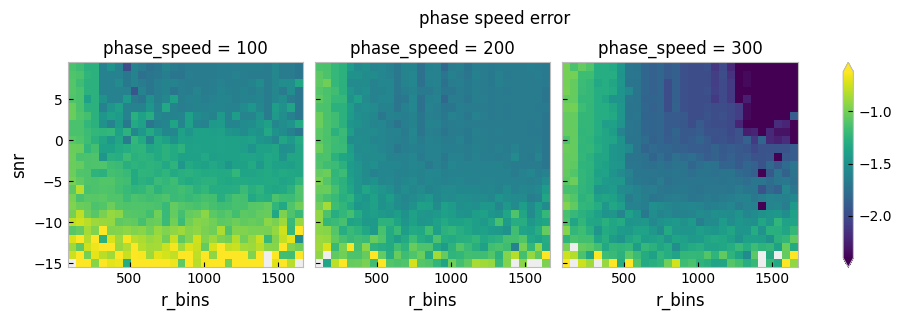

<Figure size 640x480 with 0 Axes>

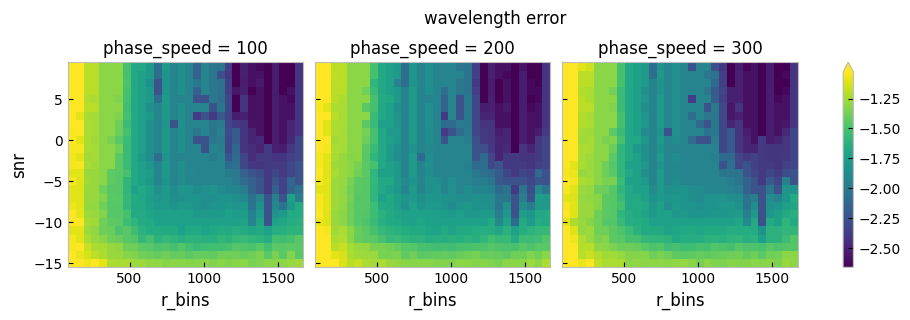

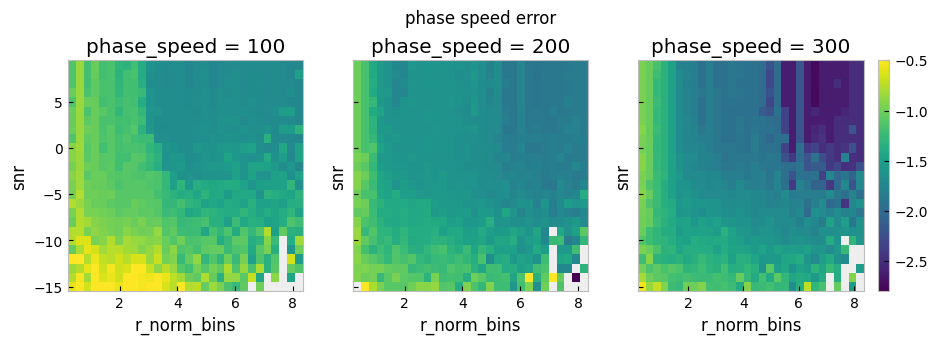

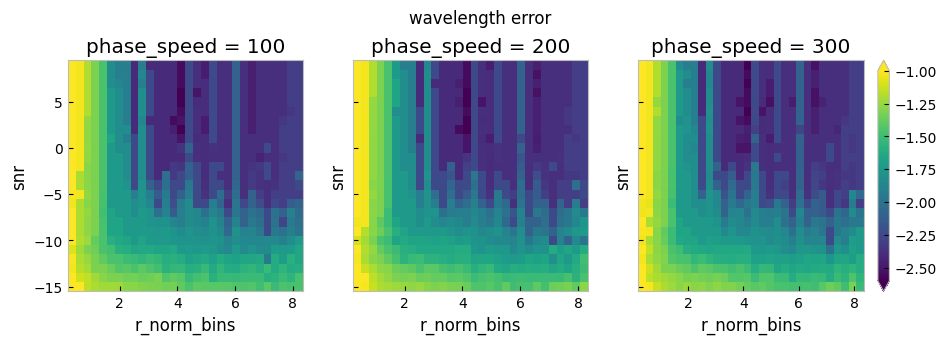

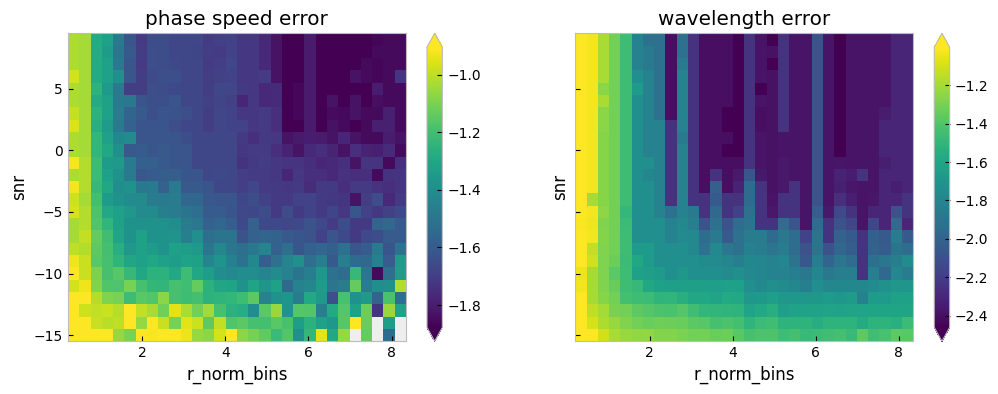

In [72]:
## WAVELENGTH
plt.figure()
g = np.log10(abs(results.ps_error / results.phase_speed)).median(["time", "phase_speed"]).groupby_bins("r", bins=30).median().plot(robust=True, center=False, col="wavelength")
plt.suptitle("phase speed error", y=1.05)
plt.figure()
np.log10(abs(results.wl_error / results.wavelength)).median(["time", "phase_speed"]).groupby_bins("r", bins=30).median().plot(robust=True, center=False, col="wavelength")
plt.suptitle("wavelength error", y=1.05)

fig1, ax1 = plt.subplots(1, 3, sharey=True, figsize=(11, 3), width_ratios=[1, 1, 1.2])
plt.suptitle("phase speed error", y=1.05)
fig2, ax2 = plt.subplots(1, 3, sharey=True, figsize=(11, 3), width_ratios=[1, 1, 1.2])
plt.suptitle("wavelength error", y=1.05)
for ii in range(results.wavelength.shape[0]):
    np.log10(abs(results.ps_error / results.phase_speed)).isel(wavelength=ii).median(["time", "phase_speed"]).groupby_bins("r_norm", bins=30).median().plot(robust=True, center=False, vmax=-.5, vmin=-2.8, ax=ax1[ii], add_colorbar=ii==results.wavelength.shape[0]-1)
    np.log10(abs(results.wl_error / results.wavelength)).isel(wavelength=ii).median(["time", "phase_speed"]).groupby_bins("r_norm", bins=30).median().plot(robust=True, center=False, vmax=-1, vmin=-2.6, ax=ax2[ii], add_colorbar=ii==results.wavelength.shape[0]-1)

## PHASE SPEED
plt.figure()
np.log10(abs(results.ps_error / results.phase_speed)).median(["time", "wavelength"]).groupby_bins("r", bins=30).median().plot(robust=True, center=False, col="phase_speed")
plt.suptitle("phase speed error", y=1.05)
plt.figure()
np.log10(abs(results.wl_error / results.wavelength)).median(["time", "wavelength"]).groupby_bins("r", bins=30).median().plot(robust=True, center=False, col="phase_speed")
plt.suptitle("wavelength error", y=1.05)

fig1, ax1 = plt.subplots(1, 3, sharey=True, figsize=(11, 3), width_ratios=[1, 1, 1.2])
plt.suptitle("phase speed error", y=1.05)
fig2, ax2 = plt.subplots(1, 3, sharey=True, figsize=(11, 3), width_ratios=[1, 1, 1.2])
plt.suptitle("wavelength error", y=1.05)
for ii in range(results.phase_speed.shape[0]):
    np.log10(abs(results.ps_error / results.phase_speed)).isel(phase_speed=ii).median(["time"]).groupby_bins("r_norm", bins=30).median().plot(robust=True, center=False, vmax=-.5, vmin=-2.8, ax=ax1[ii], add_colorbar=ii==results.phase_speed.shape[0]-1)
    np.log10(abs(results.wl_error / results.wavelength)).isel(phase_speed=ii).median(["time"]).groupby_bins("r_norm", bins=30).median().plot(robust=True, center=False, vmax=-1, vmin=-2.6, ax=ax2[ii], add_colorbar=ii==results.phase_speed.shape[0]-1)

## ALL
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4))
np.log10(abs(results.ps_error / results.phase_speed)).median(["time", "phase_speed"]).groupby_bins("r_norm", bins=30).median().plot(robust=True, center=False, ax=ax[0])
np.log10(abs(results.wl_error / results.wavelength)).median(["time", "phase_speed"]).groupby_bins("r_norm", bins=30).median().plot(robust=True, center=False, ax=ax[1])
ax[0].set_title("phase speed error")
ax[1].set_title("wavelength error")

period = 25.0


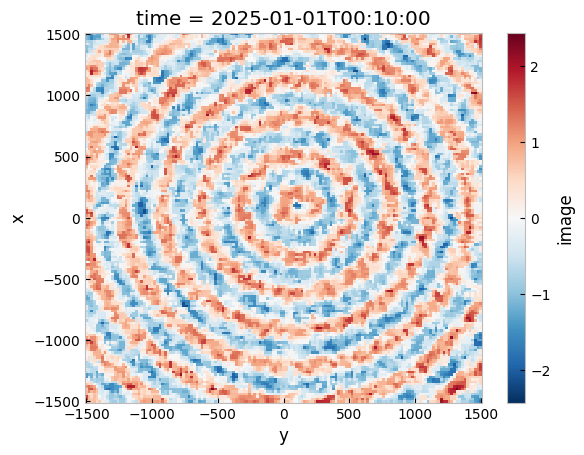

In [36]:
import gnss_tid.image
import gnss_tid.synthetic
import gnss_tid.parameter

center = xarray.DataArray([100, 100], dims=["ci"])
wavelength = 300.0
phase_speed = 200.0
period = wavelength * 1000 / (60 * phase_speed)
print(f"{period = }")

data_syn = gnss_tid.synthetic.constant_model(
    center=center,
    wavelength=wavelength,
    phase_speed=phase_speed,
    xlim=(-1500, 1500),
    ylim=(-1500, 1500),
    snr=-3,
    hres=20,
)
data_syn["image"] = data_syn["image"].rolling(x=3, y=3, center=True, min_periods=1).median()
data_syn["image"].isel(time=10).plot()
params_syn, tau_syn, patches_syn = gnss_tid.parameter.estimate_parameters_block(data_syn, kaiser_beta=5, Nfft=256)


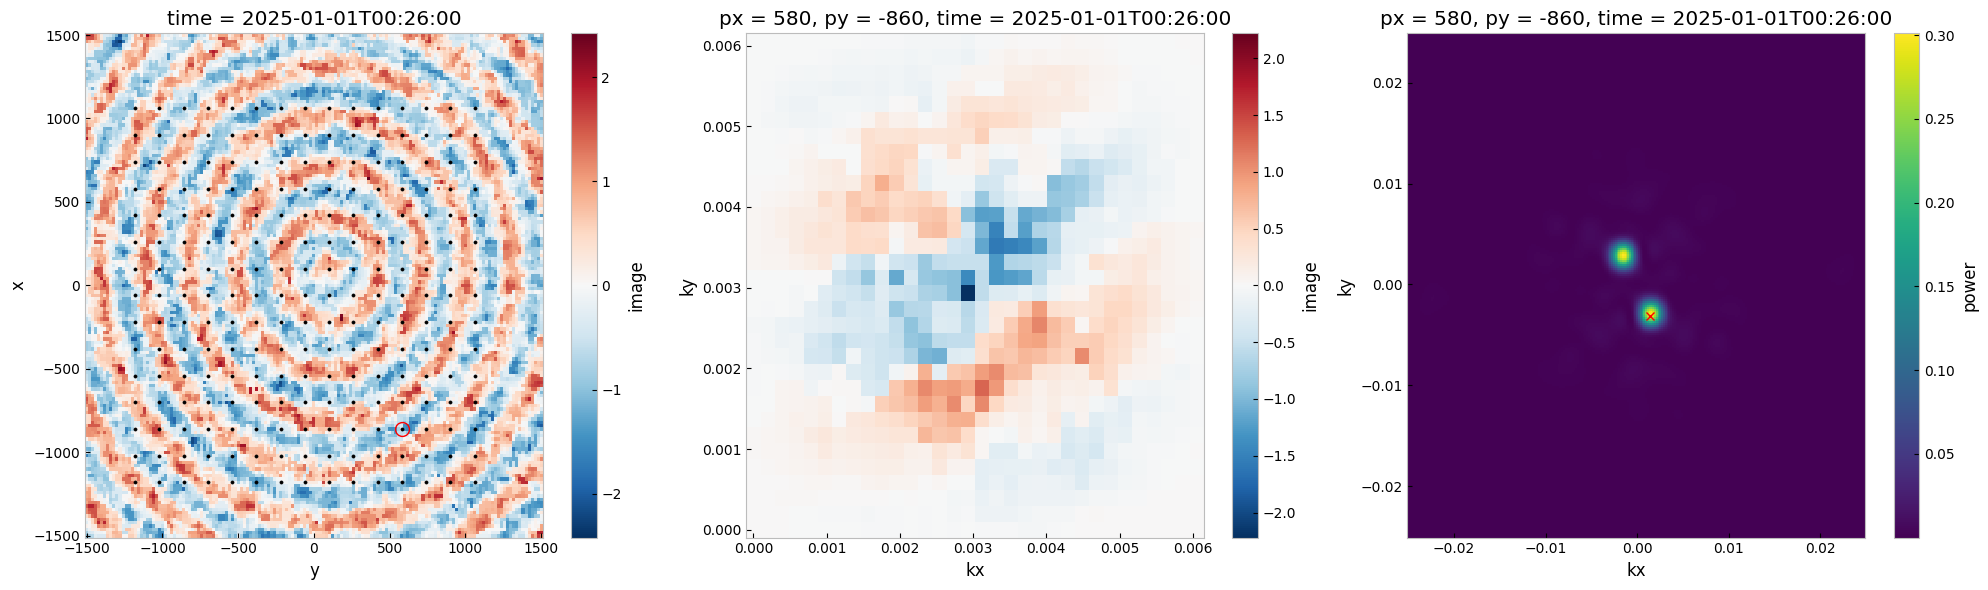

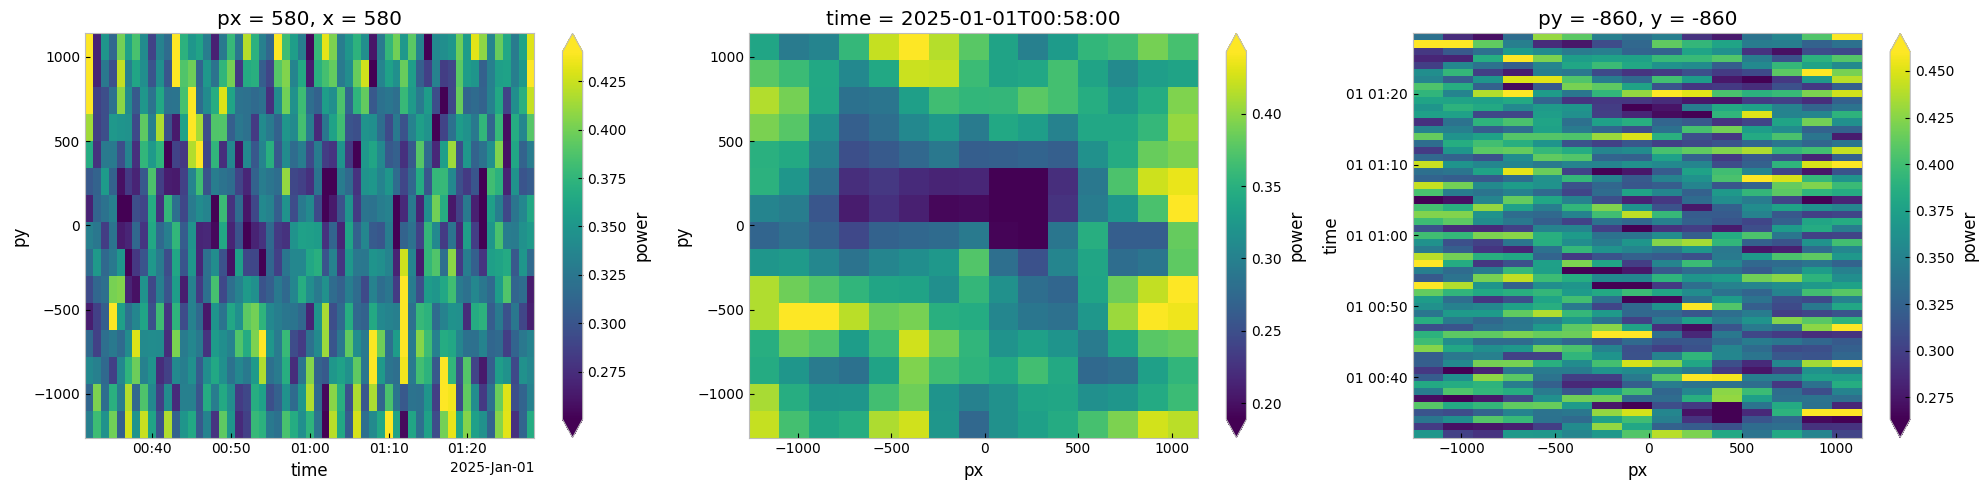

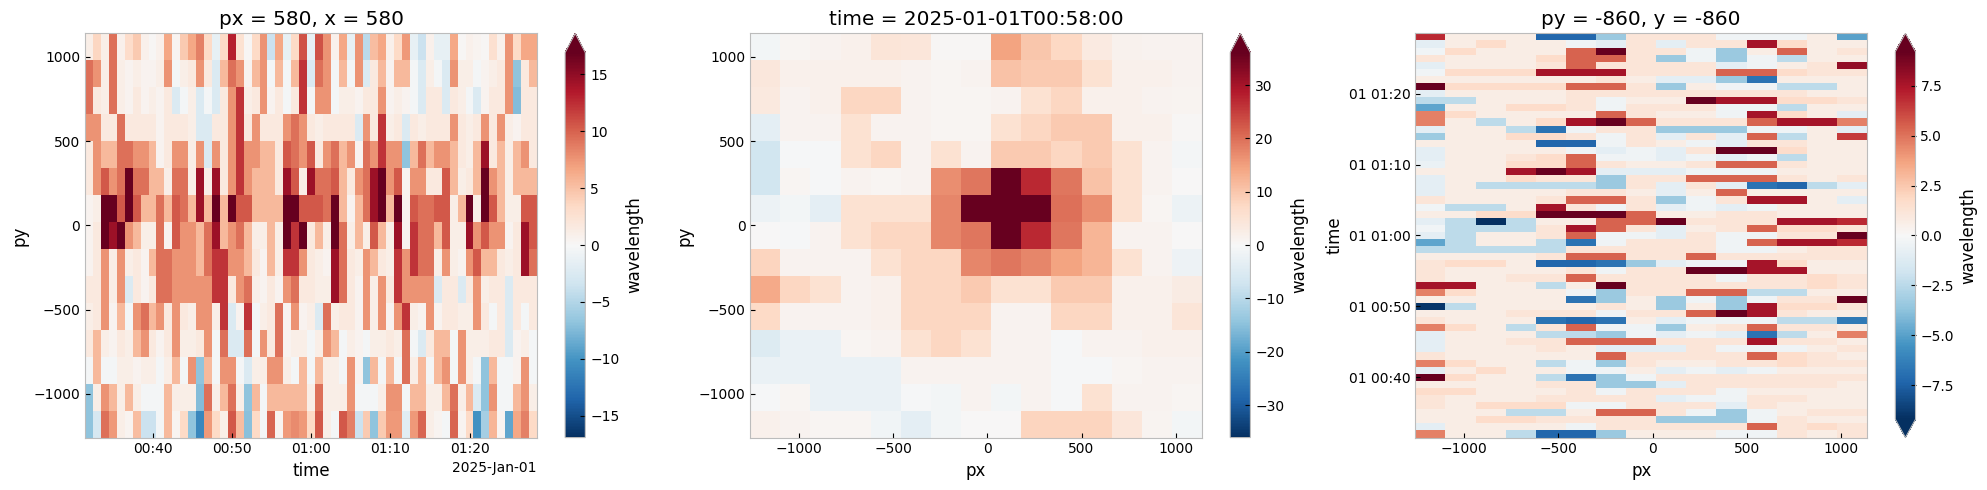

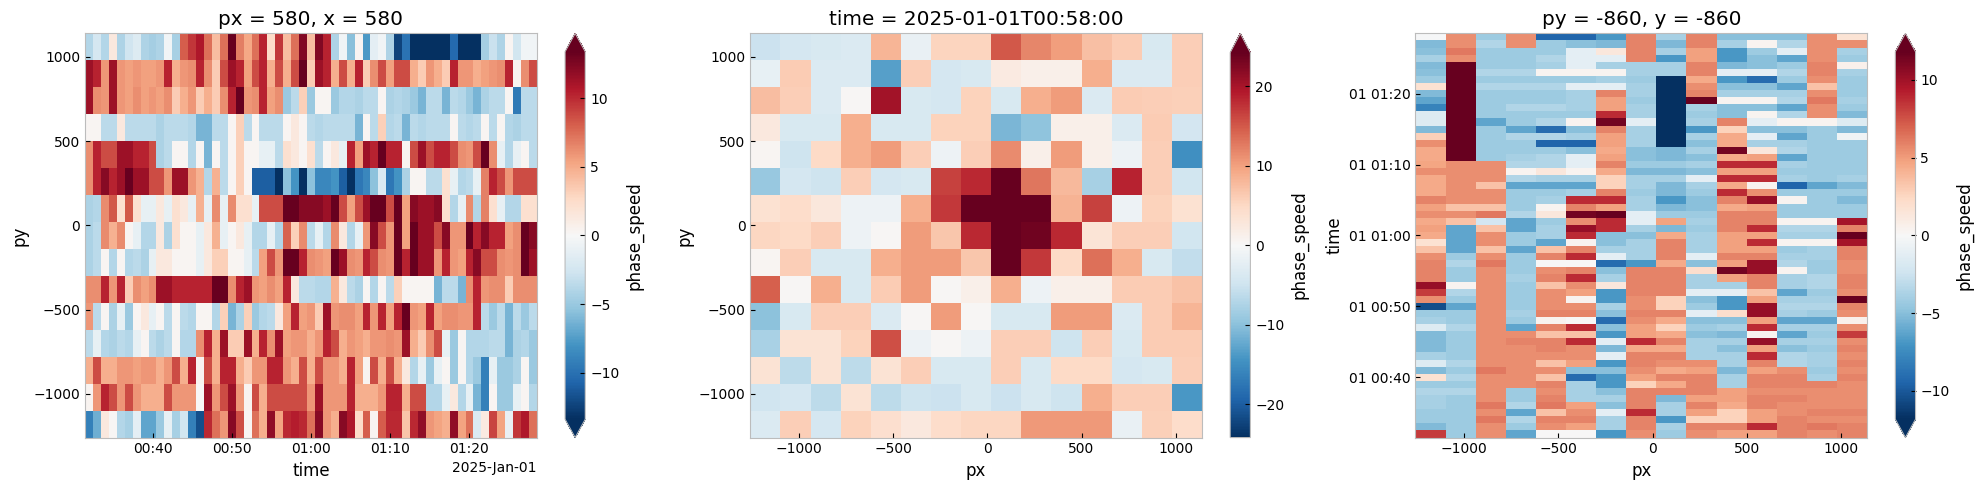

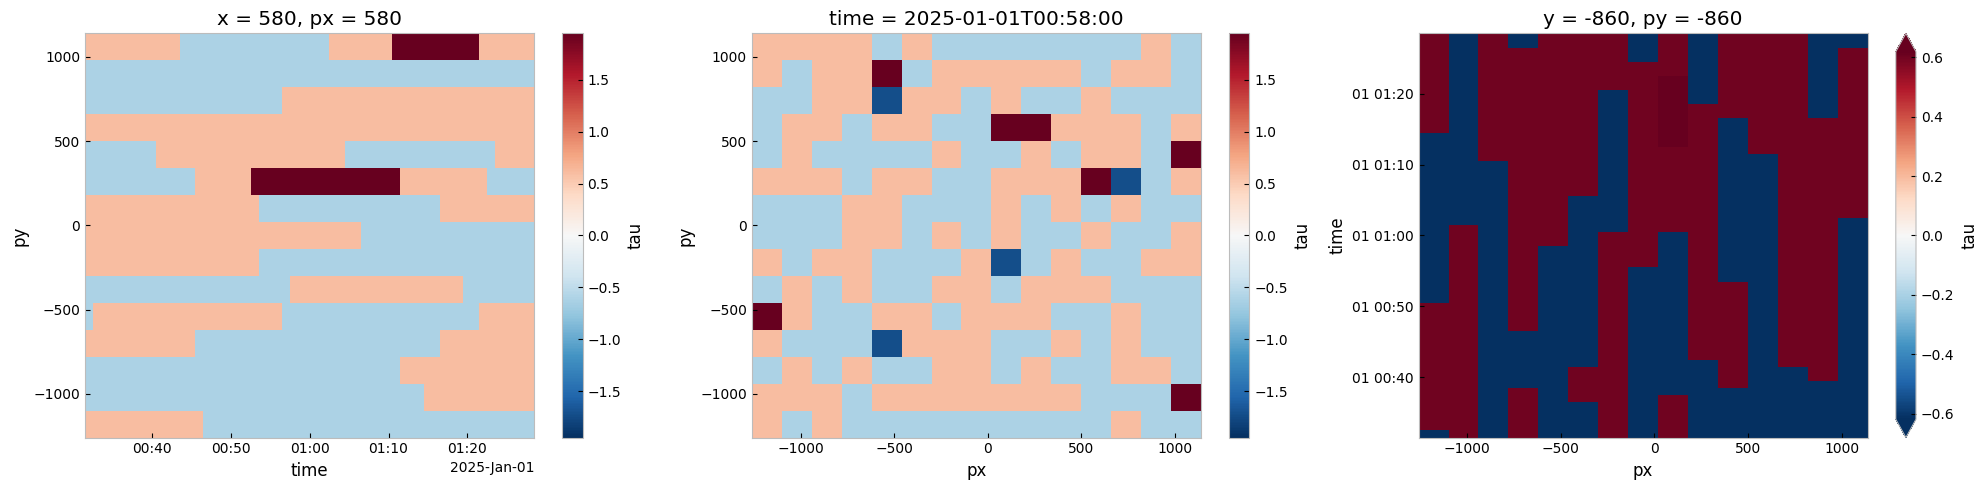

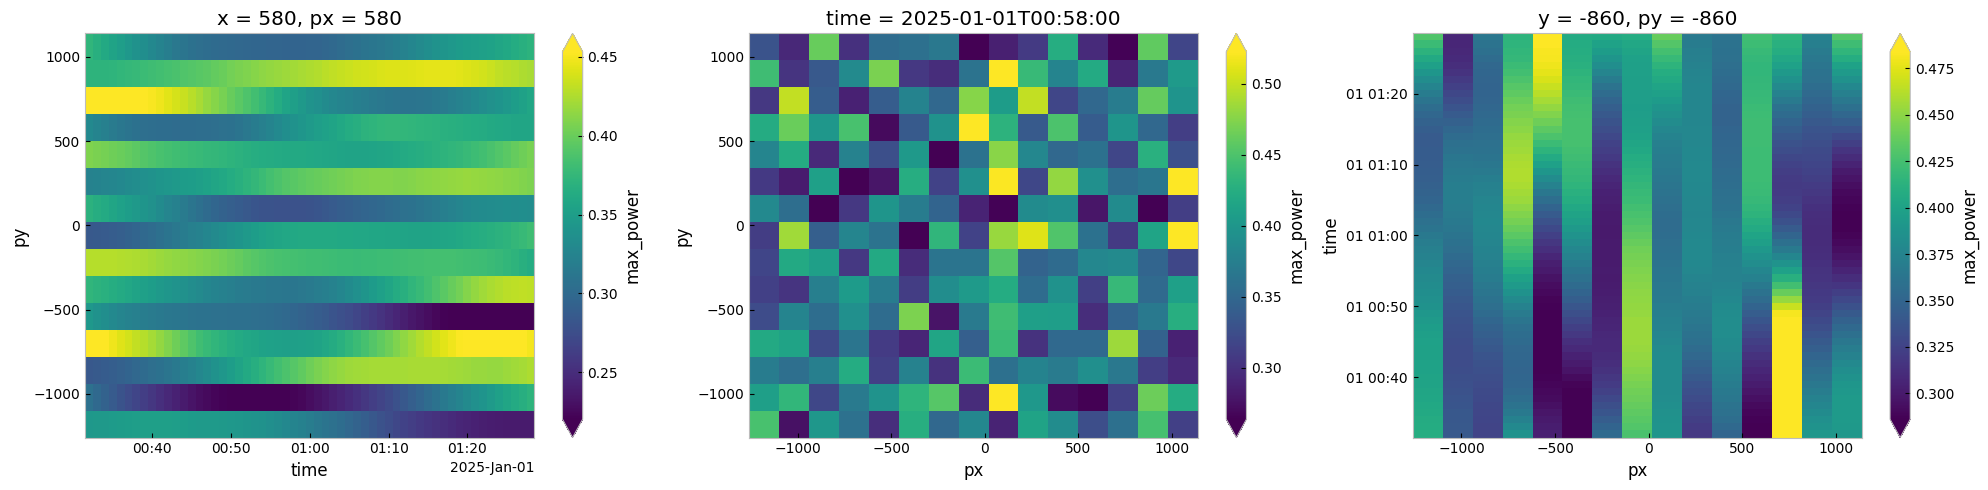

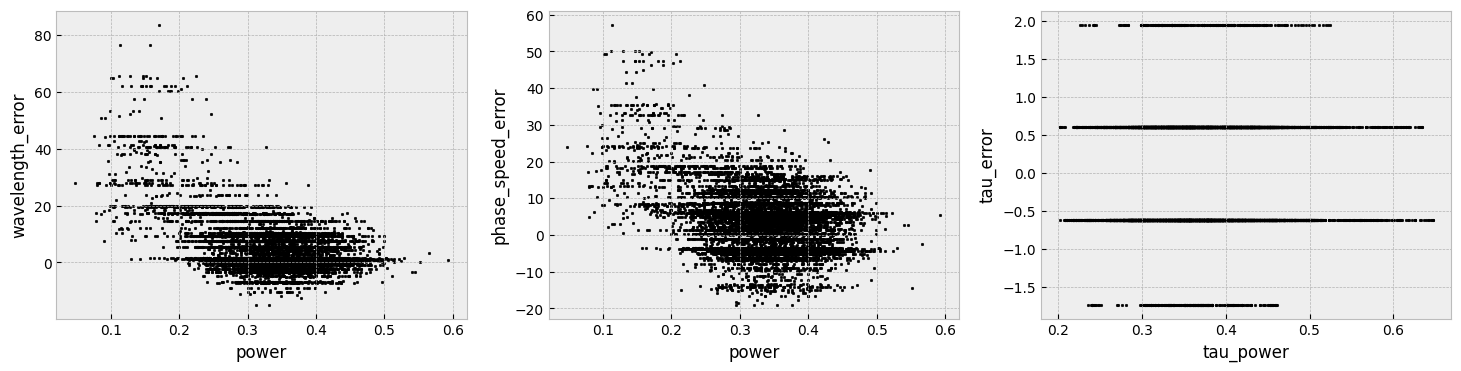

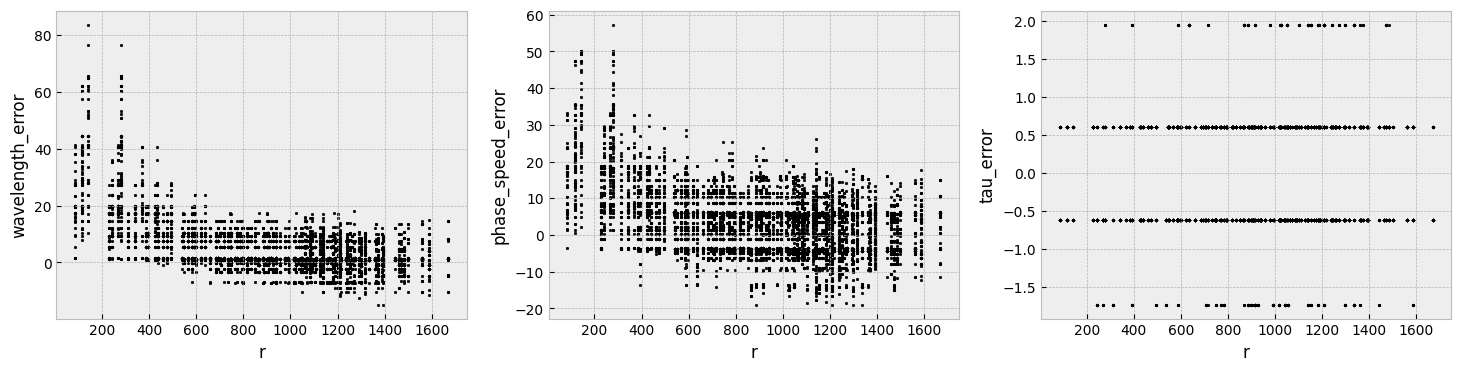

In [37]:
# PHASE PLOTS
def plot_param_3plane(params, name, TI, XI, YI, val):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5), tight_layout=True)
    (params[name] - val).isel(px=XI).plot(ax=ax[0], x="time", y="py", robust=True)
    # ax[0].axvline(params.time[TI].values, c="k", linestyle="--")
    # ax[0].axhline(params.py[YI].values, c="k", linestyle="--")
    (params[name] - val).isel(time=TI).plot(ax=ax[1], x="px", y="py", robust=True)
    # ax[1].axvline(params.px[XI].values, c="k", linestyle="--")
    # ax[1].axhline(params.py[YI].values, c="k", linestyle="--")
    # ax[1].plot(params.px[XI].values, params.py[YI].values, 'ko')
    (params[name] - val).isel(py=YI).plot(ax=ax[2], x="px", y="time", robust=True)
    # ax[2].axvline(params.px[XI].values, c="k", linestyle="--")
    # ax[2].axhline(params.time[TI].values, c="k", linestyle="--")


XI = 11
YI = -13
TI = 26

az_coords = np.arange(230, 270, 10)
range_coords = np.arange(300, 1200, 50)
cx0, cy0 = data_syn.center.values[0], data_syn.center.values[1]  # TID center
lines_x, lines_y = gnss_tid.parameter.get_line_coordinates(cx0, cy0, az_coords, range_coords)
lines_x = xarray.DataArray(
    lines_x, coords={"r": range_coords, "az": az_coords}, dims=["r", "az"]
)
lines_y = xarray.DataArray(
    lines_y, coords={"r": range_coords, "az": az_coords}, dims=["r", "az"]
)

# ## RADIAL LINES
# fig, ax = plt.subplots(1, 3, figsize=(18, 4))
# params_syn.wavelength.interp(px=lines_x, py=lines_y).isel(time=TI).plot(hue="az", ax=ax[0])
# t = tau_syn.tau.interp(px=lines_x, py=lines_y).isel(time=TI)
# t.plot(hue="az", ax=ax[1])
# params_syn.phase_speed.interp(px=lines_x, py=lines_y).isel(time=TI).plot(hue="az", ax=ax[2])

## PATCH
fig, ax = plt.subplots(1, 3, figsize=(20, 6), tight_layout=True)
data_syn.image.isel(time=TI).plot(ax=ax[0])
# ax[0].plot(lines_x, lines_y)
params_syn.plot.scatter(x="px", y="py", add_labels=False, ax=ax[0], color="k", s=5)
ax[0].plot(params_syn.px[XI], params_syn.py[YI], 'ro', markersize=10, markerfacecolor="none")
patches_syn.image.isel(px=XI, py=YI, time=TI, kx=slice(params_syn.block_size), ky=slice(params_syn.block_size)).plot(ax=ax[1])
patches_syn.power.isel(px=XI, py=YI, time=TI).sortby(["kx", "ky"]).plot(ax=ax[2])
ax[2].plot(params_syn.power.isel(px=XI, py=YI, time=TI).kx, params_syn.power.isel(px=XI, py=YI, time=TI).ky, 'rx')

## PARAMS
plot_param_3plane(params_syn, "power", TI, XI, YI, 0)
plot_param_3plane(params_syn, "wavelength", TI, XI, YI, wavelength)
plot_param_3plane(params_syn, "phase_speed", TI, XI, YI, phase_speed)
plot_param_3plane(tau_syn, "tau", TI, XI, YI, period)
plot_param_3plane(tau_syn, "max_power", TI, XI, YI, 0)

errors = xarray.Dataset({
    "wavelength_error": (params_syn.wavelength - wavelength),
    "phase_speed_error": (params_syn.phase_speed - phase_speed),
    "power": params_syn.power,
    "tau_error": (tau_syn.tau - period),
    "tau_power": tau_syn.max_power,
    "r": np.hypot(params_syn.px, params_syn.py),
})

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
errors.plot.scatter(x="power", y="wavelength_error", ax=ax[0], color="k", s=3)
errors.plot.scatter(x="power", y="phase_speed_error", ax=ax[1], color="k", s=3)
errors.plot.scatter(x="tau_power", y="tau_error", ax=ax[2], color="k", s=3)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
errors.plot.scatter(x="r", y="wavelength_error", ax=ax[0], color="k", s=3)
errors.plot.scatter(x="r", y="phase_speed_error", ax=ax[1], color="k", s=3)
errors.plot.scatter(x="r", y="tau_error", ax=ax[2], color="k", s=3)


In [29]:
import gnss_tid.image
import gnss_tid.synthetic
import gnss_tid.parameter

file = "outputs/2024-12-06/22-20-41/autofocus.h5"
data = xarray.open_dataset(file)
params, tau, patches = gnss_tid.parameter.estimate_parameters_block(data, space_power_threshold=.1, time_power_threshold=.2, time_window=64)

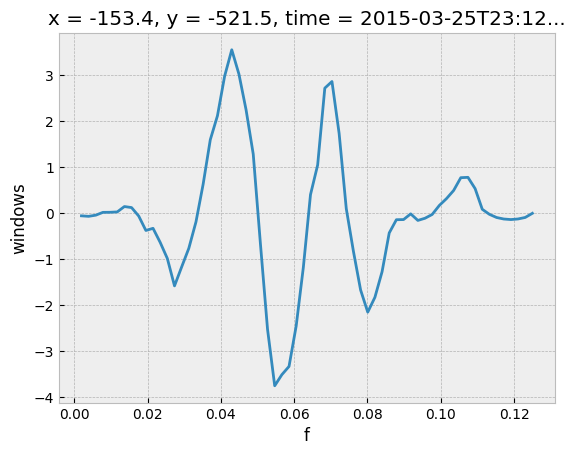

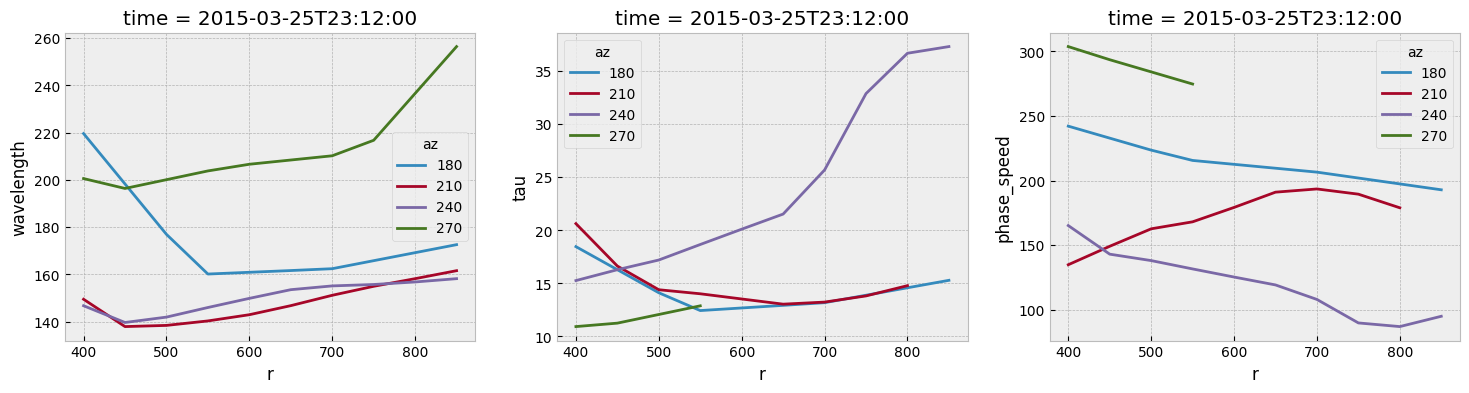

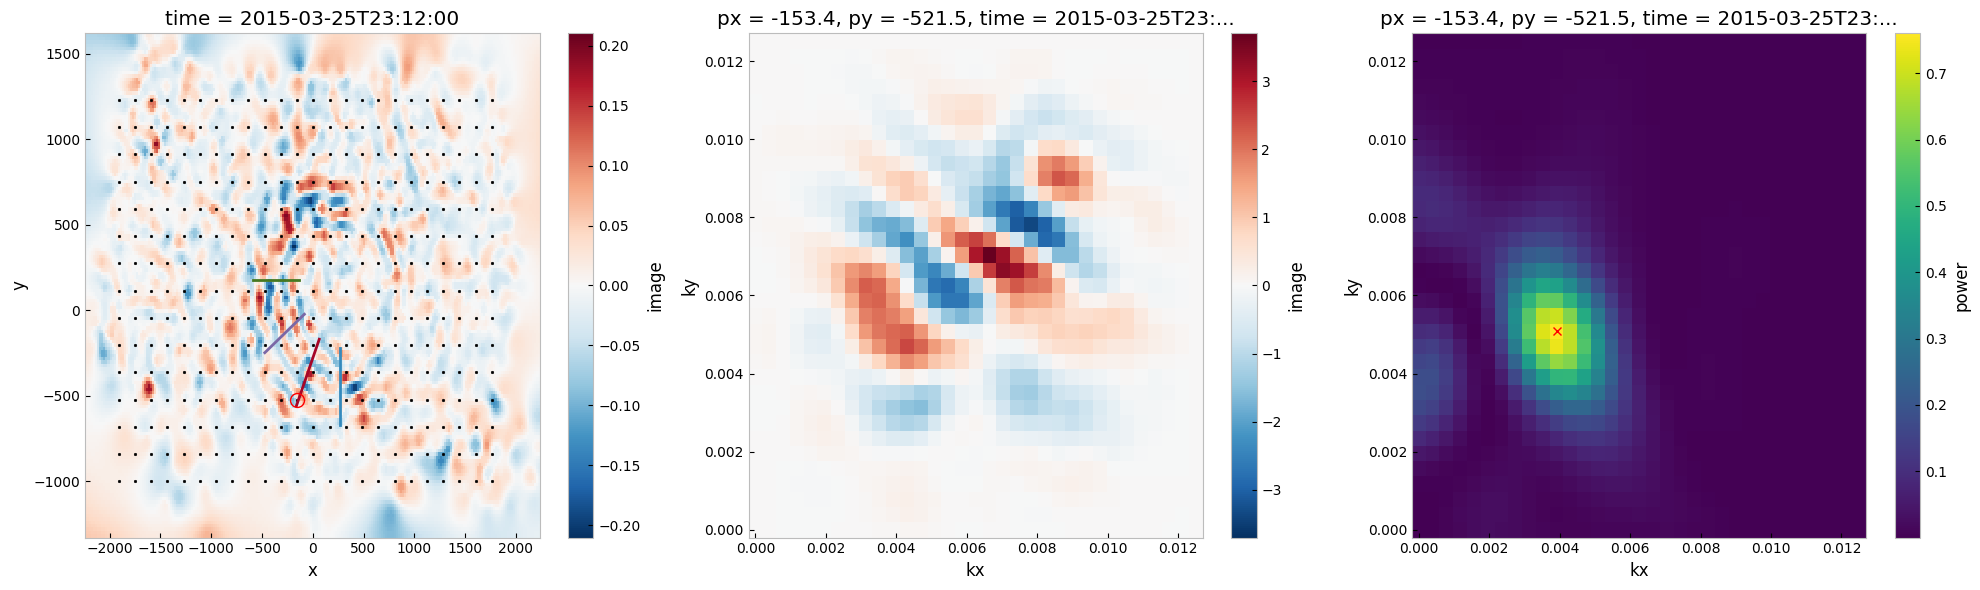

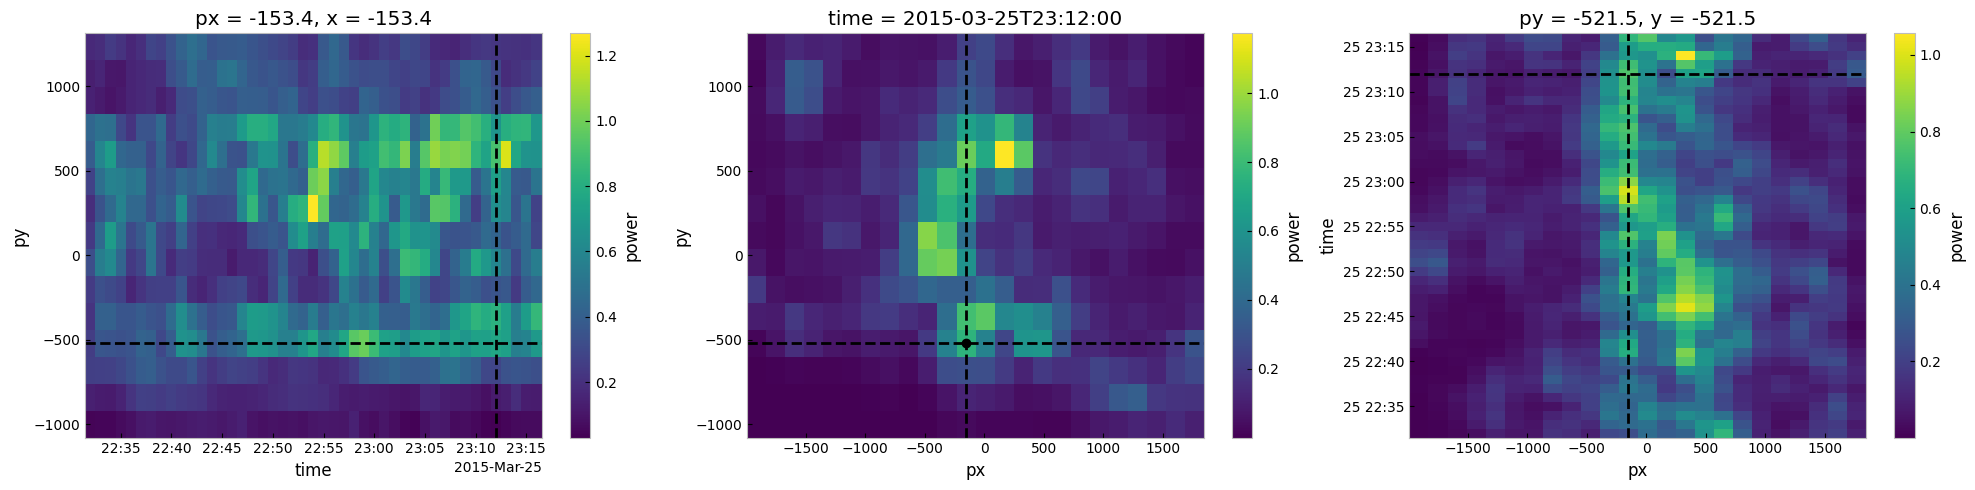

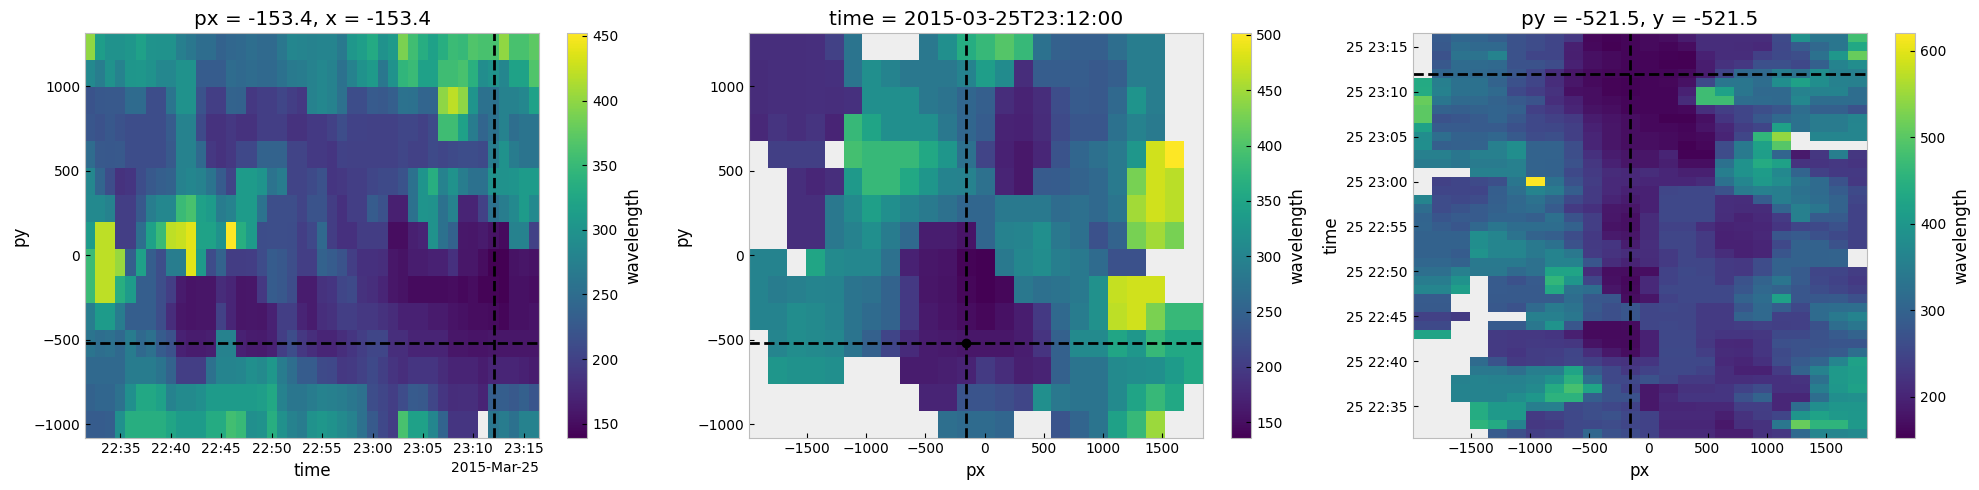

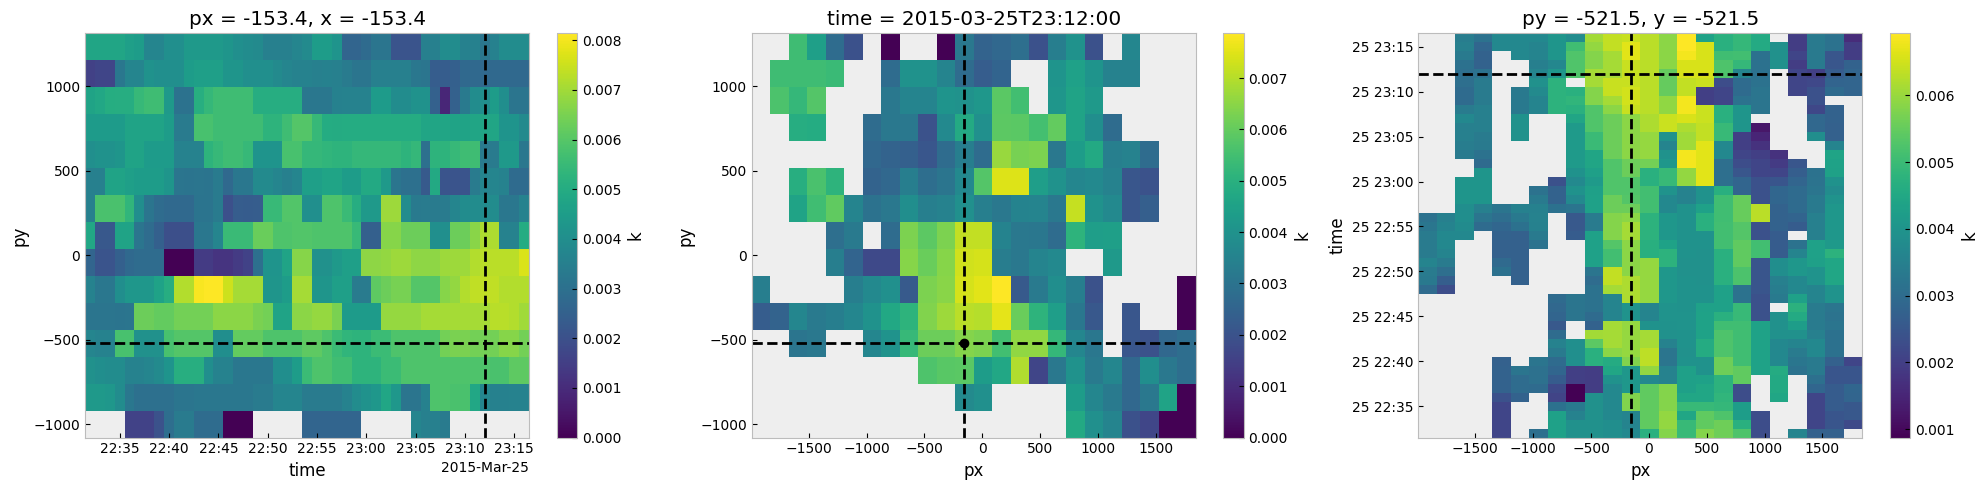

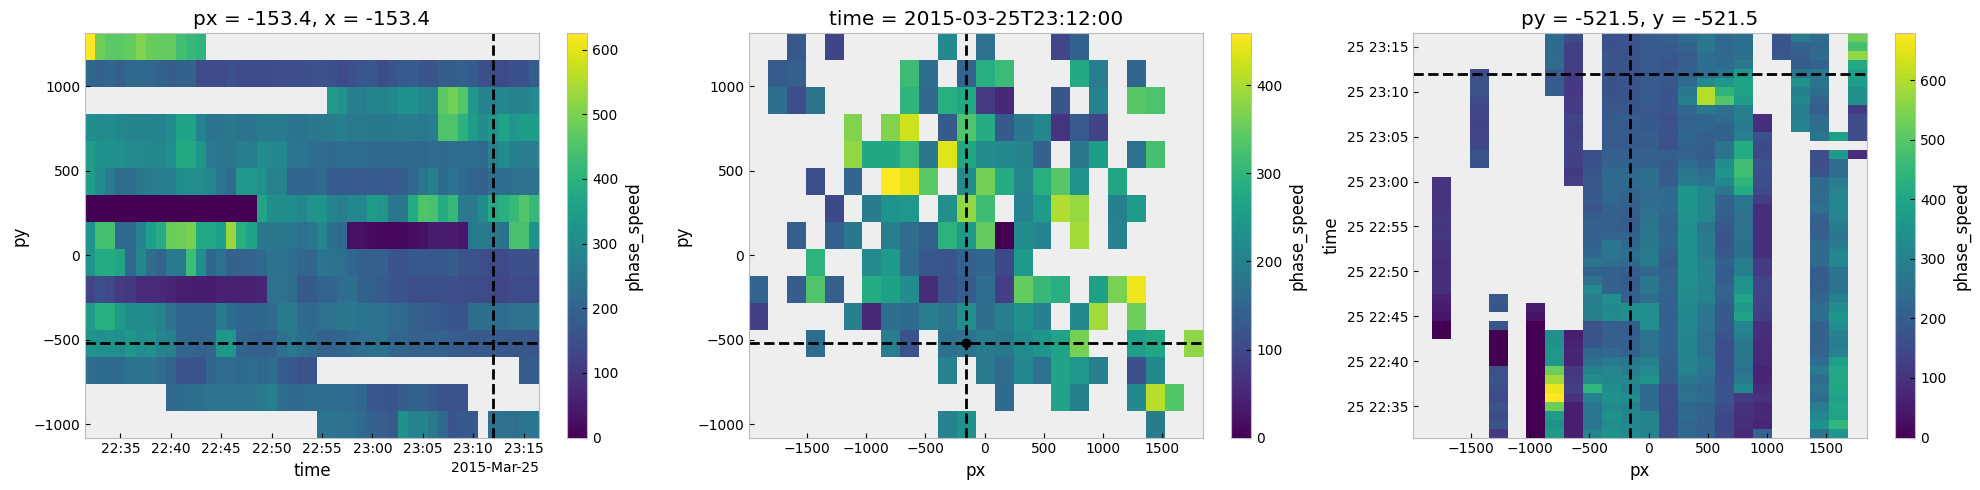

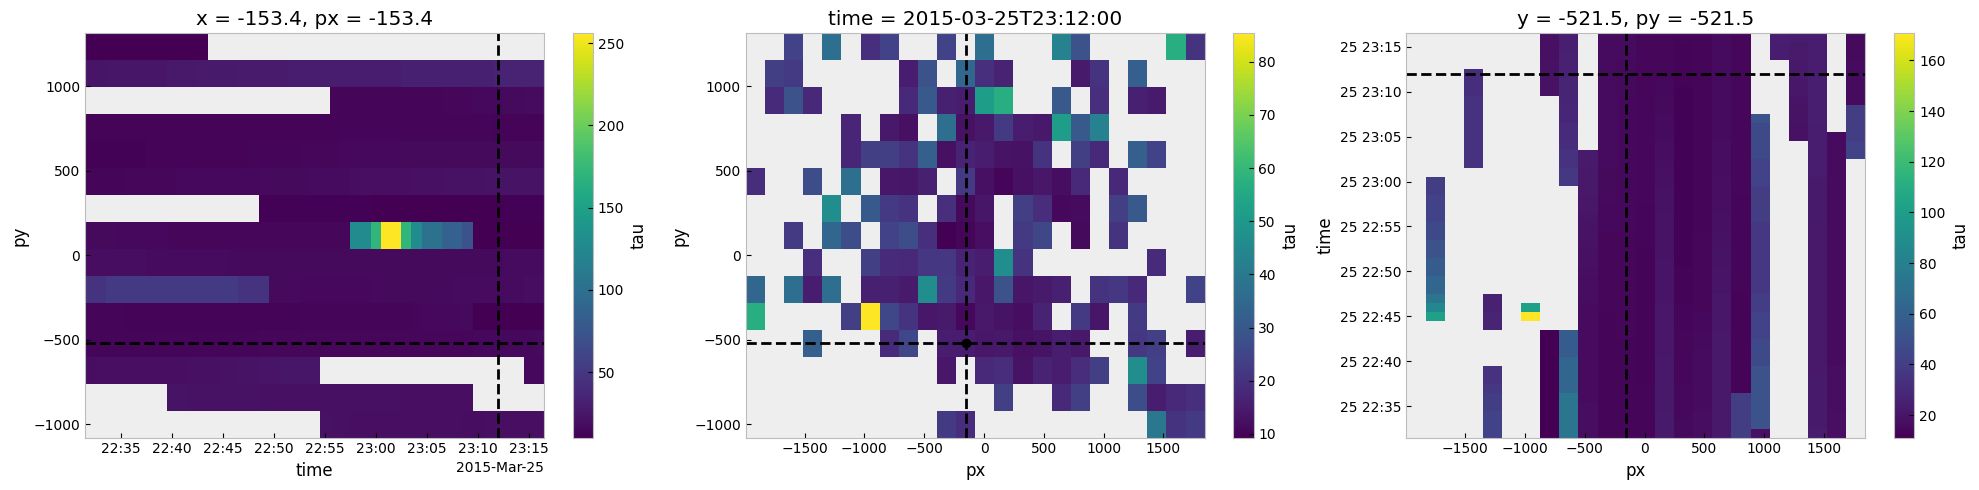

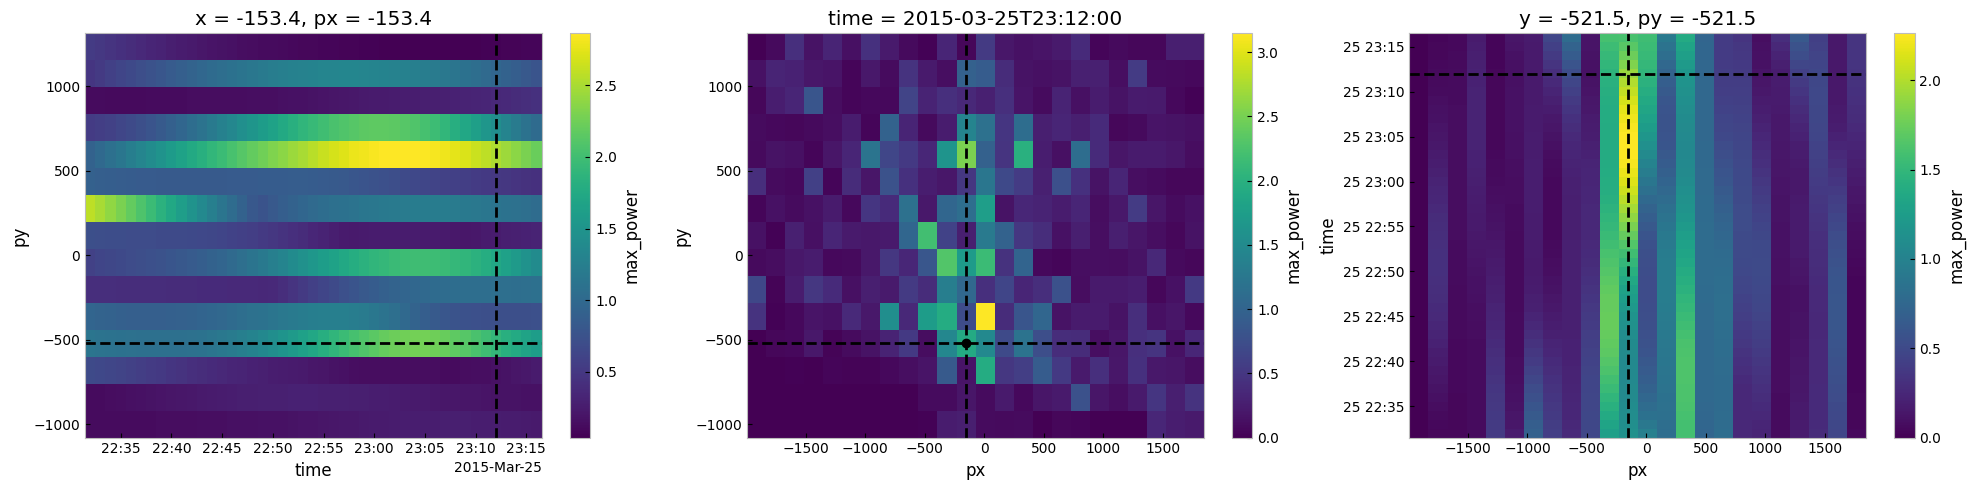

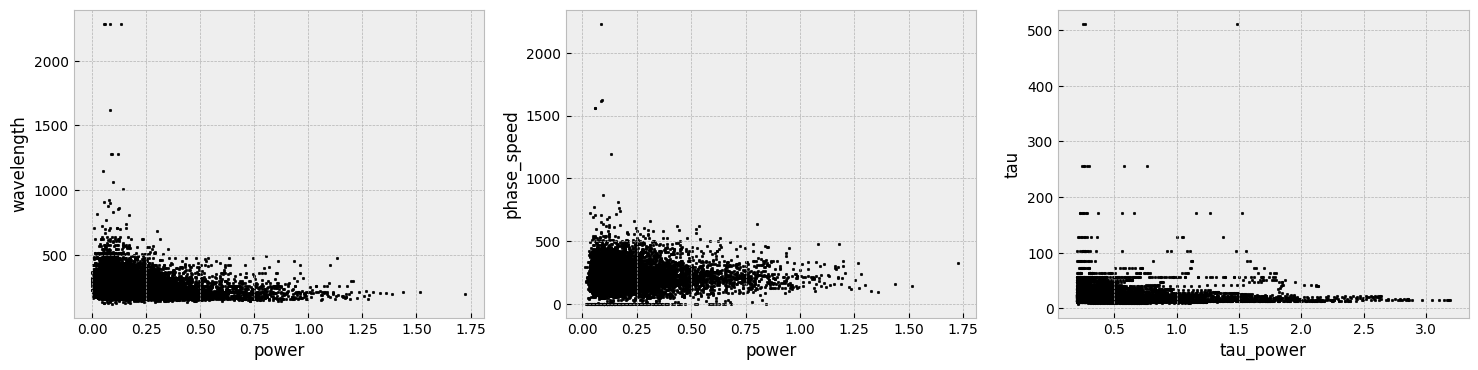

In [30]:
# PHASE PLOTS
def plot_param_3plane(params, name, TI, XI, YI, val):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5), tight_layout=True)
    (params[name] - val).isel(px=XI).plot(ax=ax[0], x="time", y="py")
    ax[0].axvline(params.time[TI].values, c="k", linestyle="--")
    ax[0].axhline(params.py[YI].values, c="k", linestyle="--")
    (params[name] - val).isel(time=TI).plot(ax=ax[1], x="px", y="py")
    ax[1].axvline(params.px[XI].values, c="k", linestyle="--")
    ax[1].axhline(params.py[YI].values, c="k", linestyle="--")
    ax[1].plot(params.px[XI].values, params.py[YI].values, 'ko')
    (params[name] - val).isel(py=YI).plot(ax=ax[2], x="px", y="time")
    ax[2].axvline(params.px[XI].values, c="k", linestyle="--")
    ax[2].axhline(params.time[TI].values, c="k", linestyle="--")


XI = 11
YI = 3
TI = 40

az_coords = np.arange(180, 280, 30)
range_coords = np.arange(400, 900, 50)
cx0, cy0 = data.center.values[0], data.center.values[1]  # TID center
lines_x, lines_y = gnss_tid.parameter.get_line_coordinates(cx0, cy0, az_coords, range_coords)
lines_x = xarray.DataArray(
    lines_x, coords={"r": range_coords, "az": az_coords}, dims=["r", "az"]
)
lines_y = xarray.DataArray(
    lines_y, coords={"r": range_coords, "az": az_coords}, dims=["r", "az"]
)

plt.figure()
Q = tau.windows.isel(px=XI, py=YI, time=TI, f=slice(params.time_nfft//2 + 1, params.time_nfft//2 + 1 + params.time_window))
Q.plot()

## RADIAL
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
params.wavelength.interp(px=lines_x, py=lines_y).isel(time=TI).plot(hue="az", ax=ax[0])
t = tau.tau.interp(px=lines_x, py=lines_y).isel(time=TI)
t.plot(hue="az", ax=ax[1])
params.phase_speed.interp(px=lines_x, py=lines_y).isel(time=TI).plot(hue="az", ax=ax[2])

## PATCH
fig, ax = plt.subplots(1, 3, figsize=(20, 6), tight_layout=True)
data.image.sel(time=params.time[TI]).rolling(x=3, y=3, center=True, min_periods=1).median().plot(ax=ax[0])
ax[0].plot(lines_x, lines_y)
params.plot.scatter(x="px", y="py", add_labels=False, ax=ax[0], color="k", s=3)
ax[0].plot(params.px[XI], params.py[YI], 'ro', markersize=10, markerfacecolor="none")
patches.image.sel(time=params.time[TI]).isel(px=XI, py=YI, kx=slice(params.block_size + 1), ky=slice(params.block_size + 1)).plot(ax=ax[1])
patches.power.sel(time=params.time[TI]).isel(px=XI, py=YI, kx=slice(params.block_size + 1), ky=slice(params.block_size + 1)).plot(ax=ax[2])
ax[2].plot(params.power.isel(px=XI, py=YI, time=TI).kx, params.power.isel(px=XI, py=YI, time=TI).ky, 'rx')

## PARAMS
plot_param_3plane(params, "power", TI, XI, YI, 0)
plot_param_3plane(params, "wavelength", TI, XI, YI, 0)
plot_param_3plane(params, "k", TI, XI, YI, 0)
plot_param_3plane(params, "phase_speed", TI, XI, YI, 0)
plot_param_3plane(tau, "tau", TI, XI, YI, 0)
plot_param_3plane(tau, "max_power", TI, XI, YI, 0)

errors = xarray.Dataset({
    "wavelength": params.wavelength,
    "phase_speed": params.phase_speed,
    "power": params.power,
    "tau": tau.tau,
    "tau_power": tau.max_power,
})

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
errors.plot.scatter(x="power", y="wavelength", ax=ax[0], color="k", s=3)
errors.plot.scatter(x="power", y="phase_speed", ax=ax[1], color="k", s=3)
errors.plot.scatter(x="tau_power", y="tau", ax=ax[2], color="k", s=3)

/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/missing.py:589: RuntimeWarning: All-NaN axis encountered
  minval = np.nanmin(new_x_loaded)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/missing.py:590: RuntimeWarning: All-NaN axis encountered
  maxval = np.nanmax(new_x_loaded)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/missing.py:589: RuntimeWarning: All-NaN axis encountered
  minval = np.nanmin(new_x_loaded)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/core/missing.py:590: RuntimeWarning: All-NaN axis encountered
  maxval = np.nanmax(new_x_loaded)


<Figure size 640x480 with 0 Axes>

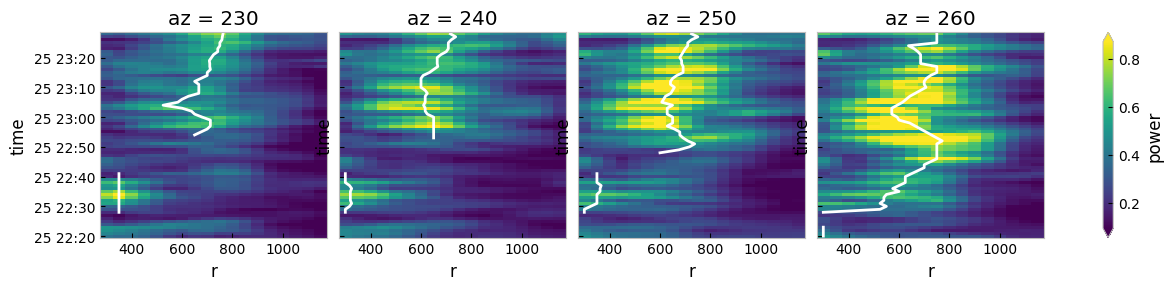

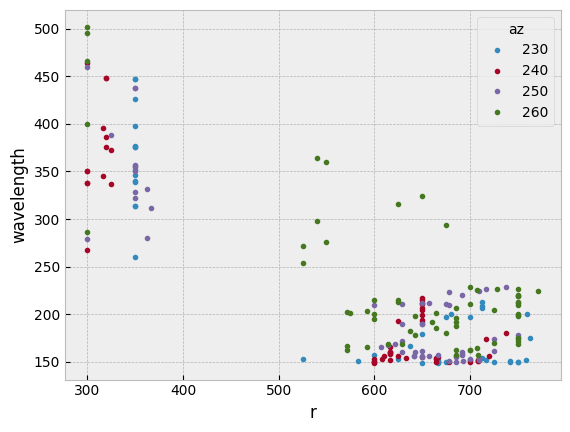

<Figure size 640x480 with 0 Axes>

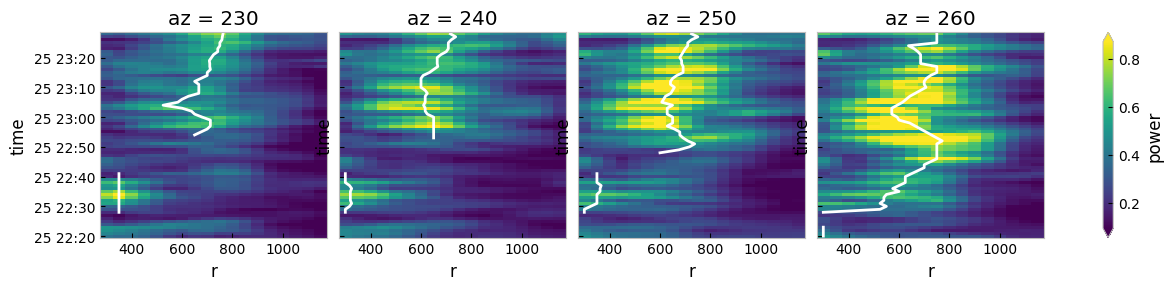

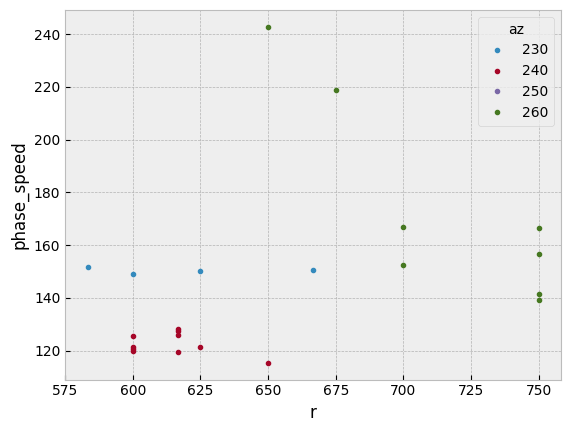

<Figure size 640x480 with 0 Axes>

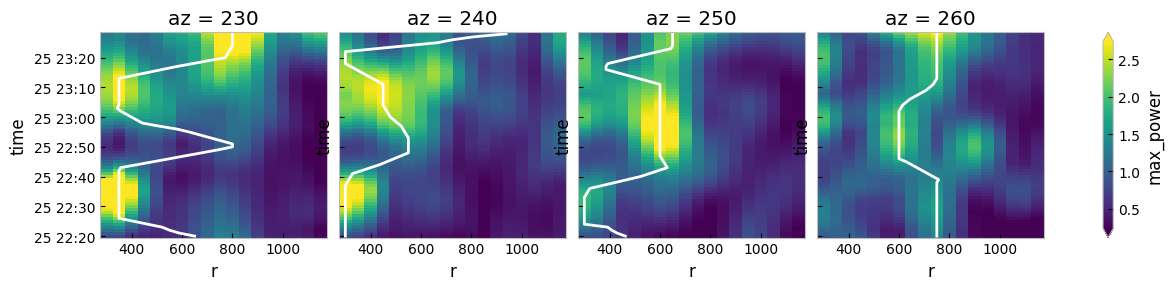

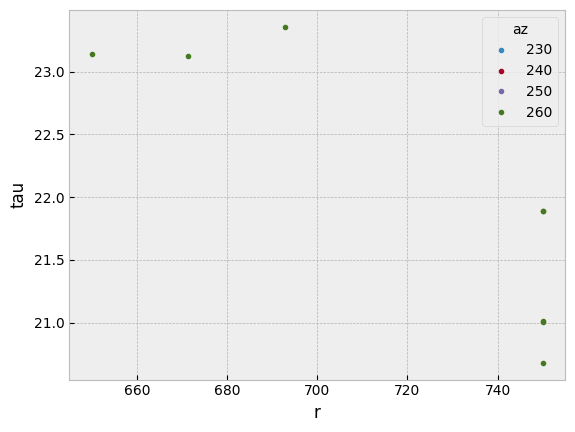

In [15]:
def radial_param(power, parm, lines_x, lines_y):
    line_power = power.interp(px=lines_x, py=lines_y)
    line_parm = parm.interp(px=lines_x, py=lines_y)
    lpr = (
        line_power.r
        .isel(r=line_power.argmax("r"))
        .where((line_power > .5).any("r"))
        .rolling(time=7, center=True, min_periods=1).mean()
    )
    plt.figure()
    grid = line_power.plot(col="az", robust=True)
    for ii in range(line_power.az.shape[0]):
        lpr.isel(az=ii).plot(y="time", ax=grid.axs[0, ii], color="w")
    plt.figure()
    line_parm.interp(r=lpr.reset_coords("r", drop=True)).plot(x="r", hue="az", linestyle="none", marker=".")


radial_param(params.power, params.wavelength, lines_x, lines_y)
radial_param(params.power, params.phase_speed, lines_x, lines_y)
radial_param(tau.max_power, tau.tau, lines_x, lines_y)

<xarray.DataArray 'max_power' ()> Size: 8B
array(1.30151545)
Coordinates:
    x        float64 8B -313.2
    y        float64 8B -202.7
    time     datetime64[ns] 8B 2015-03-25T23:25:00
    px       float64 8B -313.2
    py       float64 8B -202.7

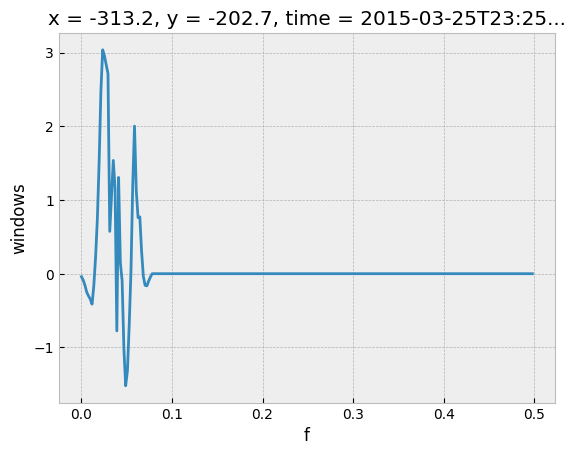

In [ ]:
Q = tau.windows.isel(px=XI, py=YI, time=TI, f=slice(256, None))
Q.plot()
tau.max_power.isel(px=XI, py=YI, time=TI)